In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.layers import Conv2D,Flatten,Dense,MaxPool2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model

In [2]:
img_height, img_width=(224,224)
batch_size=32

train_data_dir=r"basedata\processed_data\train"
valid_data_dir=r"basedata\processed_data\val"
test_data_dir=r"basedata\processed_data\test"

In [3]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=40,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=False,
                                  validation_split=0.4,
                                  brightness_range=(0.5,1.5))

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                   target_size=(img_height,img_width),
                                                   batch_size=batch_size,
                                                   class_mode='categorical',
                                                   subset='training')#set as training data

valid_generator=train_datagen.flow_from_directory(valid_data_dir,
                                                 target_size=(img_height,img_width),
                                                 batch_size=batch_size,
                                                 class_mode='categorical',
                                                 subset='validation')#set as validation data


Found 326 images belonging to 8 classes.
Found 64 images belonging to 8 classes.


In [4]:
test_generator= train_datagen.flow_from_directory(test_data_dir,
                                                 target_size=(img_height,img_width),
                                                 batch_size=1,
                                                 class_mode='categorical',
                                                 subset='validation')

Found 72 images belonging to 8 classes.


In [5]:
x,y=test_generator.next()
x.shape

(1, 224, 224, 3)

In [6]:
train_generator.num_classes

8

In [7]:
base_model = ResNet50(include_top=False,weights='imagenet')
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)
predictions=Dense(train_generator.num_classes, activation='softmax')(x)
model= Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable=False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_generator, epochs=25)

Epoch 1/25
11/11 [==============================] - 66s 5s/step - loss: 3.6878 - accuracy: 0.3160
Epoch 2/25
11/11 [==============================] - 49s 4s/step - loss: 1.4620 - accuracy: 0.5215
Epoch 3/25
11/11 [==============================] - 47s 4s/step - loss: 0.8068 - accuracy: 0.7055
Epoch 4/25
11/11 [==============================] - 48s 4s/step - loss: 0.8124 - accuracy: 0.6902
Epoch 5/25
11/11 [==============================] - 46s 4s/step - loss: 0.7137 - accuracy: 0.7730
Epoch 6/25
11/11 [==============================] - 46s 4s/step - loss: 0.7929 - accuracy: 0.7423
Epoch 7/25
11/11 [==============================] - 45s 4s/step - loss: 0.4819 - accuracy: 0.8405
Epoch 8/25
11/11 [==============================] - 45s 4s/step - loss: 0.4116 - accuracy: 0.8650
Epoch 9/25
11/11 [==============================] - 45s 4s/step - loss: 0.4750 - accuracy: 0.8190
Epoch 10/25
11/11 [==============================] - 47s 4s/step - loss: 0.4129 - accuracy: 0.8466
Epoch 11/25
11/11 [

In [8]:
model.save(r'basedata\Saved_Model\NeuralNetworks.h5')

In [9]:
test_loss,test_acc=model.evaluate(test_generator,verbose=2)
print(test_acc)

72/72 - 16s - loss: 0.3774 - accuracy: 0.9167 - 16s/epoch - 220ms/step
0.9166666865348816


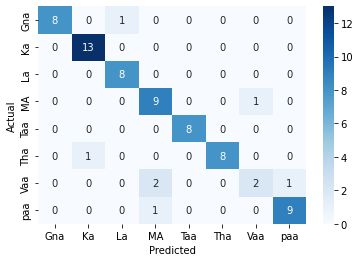

test accuracy: 90.27777777777779


In [10]:
import pandas as pd
import seaborn as sn
import tensorflow as tf

model=tf.keras.models.load_model(r"basedata\Saved_model\NeuralNetworks.h5")
filenames=test_generator.filenames
nb_samples=len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()
for _ in range(nb_samples):
    X_test,Y_test=test_generator.next()
    y_prob.append(model.predict(X_test))
    y_act.append(Y_test)
predicted_class=[list(train_generator.class_indices.keys())[i.argmax()]for i in y_prob]
actual_class=[list(train_generator.class_indices.keys())[i.argmax()]for i in y_act]

out_df=pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns=['predicted_class','actual_class'])
confusion_matrix=pd.crosstab(out_df['actual_class'],out_df['predicted_class'],rownames=['Actual'],colnames=['Predicted'])
sn.heatmap(confusion_matrix,cmap='Blues',annot=True,fmt='d')
plt.show()
print('test accuracy: {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))

In [11]:
import tensorflow as tf 
from tensorflow.python.saved_model import builder as pb_builder

In [12]:

pre_model = tf.keras.models.load_model(r"basedata\Saved_model\NeuralNetworks.h5")
pre_model.save(r"basedata\Saved_model\NeuralNetworks.h5")

In [14]:
# set learning phase to 0 since the model is already trained
tf.keras.backend.set_learning_phase(0)
#load the model
pre_model = tf.keras.models.load_model(r"basedata\Saved_model\NeuralNetworks.h5")
#convert h5 to protobuffer
builder = pb_builder.SavedModelBuilder (r'basedata\Pb3')
builder.save()

INFO:tensorflow:SavedModel written to: basedata\Pb3\saved_model.pb


b'basedata\\Pb3\\saved_model.pb'

In [15]:

builder.save(b'basedata\\Pb\\saved_model.bytes')

INFO:tensorflow:SavedModel written to: basedata\Pb3\saved_model.pbtxt


b'basedata\\Pb3\\saved_model.pbtxt'

In [22]:
import tensorflow as tf
from tensorflow.keras.models import load_model
model=load_model(r"basedata\Saved_model\NeuralNetworks.h5")
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                           

                                                                                                  
 conv2_block2_add (Add)         (None, None, None,   0           ['conv2_block1_out[0][0]',       
                                256)                              'conv2_block2_3_bn[0][0]']      
                                                                                                  
 conv2_block2_out (Activation)  (None, None, None,   0           ['conv2_block2_add[0][0]']       
                                256)                                                              
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, None, None,   16448       ['conv2_block2_out[0][0]']       
                                64)                                                               
                                                                                                  
 conv2_blo

                                128)                                                              
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, None, None,   512        ['conv3_block2_2_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, None, None,   0          ['conv3_block2_2_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, None, None,   66048       ['conv3_block2_2_relu[0][0]']    
                                512)                                                              
          

 conv4_block1_1_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_1_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, None, None,   0          ['conv4_block1_1_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block1_2_conv (Conv2D)   (None, None, None,   590080      ['conv4_block1_1_relu[0][0]']    
                                256)                                                              
                                                                                                  
 conv4_block1_2_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_2_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block3_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block3_3_conv[0][0]']    
 ization)                       1024)                                                             
                                                                                                  
 conv4_block3_add (Add)         (None, None, None,   0           ['conv4_block2_out[0][0]',       
                                1024)                             'conv4_block3_3_bn[0][0]']      
                                                                                                  
 conv4_block3_out (Activation)  (None, None, None,   0           ['conv4_block3_add[0][0]']       
                                1024)                                                             
                                                                                                  
 conv4_blo

 ization)                       256)                                                              
                                                                                                  
 conv4_block6_2_relu (Activatio  (None, None, None,   0          ['conv4_block6_2_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block6_3_conv (Conv2D)   (None, None, None,   263168      ['conv4_block6_2_relu[0][0]']    
                                1024)                                                             
                                                                                                  
 conv4_block6_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block6_3_conv[0][0]']    
 ization)                       1024)                                                             
          

 conv5_block3_1_conv (Conv2D)   (None, None, None,   1049088     ['conv5_block2_out[0][0]']       
                                512)                                                              
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, None, None,   2048       ['conv5_block3_1_conv[0][0]']    
 ization)                       512)                                                              
                                                                                                  
 conv5_block3_1_relu (Activatio  (None, None, None,   0          ['conv5_block3_1_bn[0][0]']      
 n)                             512)                                                              
                                                                                                  
 conv5_block3_2_conv (Conv2D)   (None, None, None,   2359808     ['conv5_block3_1_relu[0][0]']    
          

In [23]:
import tensorflow as tf
import tf2onnx
import onnx




onnx_model, _ = tf2onnx.convert.from_keras(model, opset=9)
onnx.save(onnx_model, r"basedata\Saved_model\model.onnx")